# **1. 데이터 처리**

In [65]:
import json
import pandas as pd
import os
import numpy as np
import glob

# ==========================================
# [1] 설정 (Configuration)
# ==========================================
# 로그 파일들이 있는 폴더 경로 (마지막에 / 없이 입력)
LOG_FOLDER_PATH = "./"  # 예: 'C:/Users/User/Desktop/logs'

OUTPUT_CSV = 'data_v3.csv'

# 파라미터
TIME_INTERVAL_SEC = 10     
START_ALIVE_THRESHOLD = 10 
AI_TEAM_ID_START = 200
MAX_AI_RATIO = 0.4         # [추가] 봇 비율 제한 (0.4 초과 시 스킵)
STALE_THRESHOLD_SEC = 30   # [v1 참고] 60초 이상 업데이트 없으면 죽은 것으로 간주

# 추적할 소모품
TRACK_CONSUMABLES = {
    # [힐]
    'Item_Heal_MedKit_C': 'medkit',
    'Item_Heal_FirstAid_C': 'firstaid',
    'Item_Boost_AdrenalineSyringe_C': 'adrenaline',
    'Item_Boost_PainKiller_C': 'painkiller',
    'Item_Boost_EnergyDrink_C': 'drink',

    # [투척]
    'Item_Weapon_Grenade_C': 'grenade',
    'Item_Weapon_SmokeBomb_C': 'smoke',
    'Item_Weapon_Molotov_C': 'molotov',
    'Item_Weapon_FlashBang_C': 'flash'
}

In [38]:
# ==========================================
# [2] 헬퍼 함수
# ==========================================
def get_item_key(item_id):
    return TRACK_CONSUMABLES.get(item_id, None)

def get_armor_info(item_id):
    if not isinstance(item_id, str): return None, 0
    level = 0
    if 'Lv3' in item_id: level = 3
    elif 'Lv2' in item_id: level = 2
    elif 'Lv1' in item_id: level = 1
    
    if 'Head' in item_id: return 'helm', level
    if 'Armor' in item_id or 'Vest' in item_id: return 'vest', level
    return None, 0

def update_player_state(p_state, name, char_obj):
    """플레이어 상태(체력, 위치, 기절) 업데이트 공통 함수"""
    if name in p_state and char_obj:
        if 'health' in char_obj:
            p_state[name]['hp'] = char_obj['health']
        if 'location' in char_obj:
            p_state[name]['loc'] = char_obj['location']
        if 'isDBNO' in char_obj:
            p_state[name]['groggy'] = 1 if char_obj['isDBNO'] else 0

In [39]:
# ==========================================
# [3] 메인 분석 로직 (v1 기반, 아이템만 추가)
# ==========================================
import orjson
import os
import pandas as pd
import numpy as np

def process_match_log(file_path):
    # --- Step 1: 파일 읽기 (orjson 사용) ---
    try:
        with open(file_path, 'rb') as f:
            logs = [orjson.loads(line) for line in f if line.strip()]
    except Exception as e:
        return None

    # --- Step 2: AI 비율 체크 ---
    all_players = set()
    human_players = set()
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character') or {}
            name = c.get('name')
            if name:
                all_players.add(name)
                if c.get('teamId', -1) < AI_TEAM_ID_START:
                    human_players.add(name)
    
    if not all_players or (1 - len(human_players)/len(all_players)) > MAX_AI_RATIO:
        return None

    # --- Step 3: 초기화 (v1과 동일) ---
    current_alive = 100
    team_players = {}
    team_ranks = {}
    p_status = {}        # {name: {hp, dbno, veh, loc, last_update}}
    p_gear = {}          # {name: {helm, vest}}
    p_throw = {}         # {name: {smoke, nade}}
    p_items = {}         # [NEW] {name: {medkit, firstaid, painkiller, drink, adrenaline, grenade, flash, molotov}}
    p_kills = {}         # {name: kill_count}
    curr_safe_zone = {'x': 400000, 'y': 400000}
    
    next_snap = 0
    recording = False
    target_teams = set()
    data_rows = []

    # --- Step 4: 팀 구성 및 순위 파악 ---
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character') or {}
            tid = c.get('teamId', -1)
            name = c.get('name')
            if tid != -1 and tid < AI_TEAM_ID_START and name:
                if tid not in team_players:
                    team_players[tid] = set()
                team_players[tid].add(name)
                if c.get('ranking', 0) != 0:
                    team_ranks[tid] = c.get('ranking')

    # --- Step 5: 로그 순차 처리 ---
    for log in logs:
        log_type = log.get('_T')
        elapsed = log.get('elapsedTime', 0)
        
        # [A] 게임 상태
        if log_type == 'LogGameStatePeriodic':
            sz = (log.get('gameState') or {}).get('safetyZonePosition') or {}
            if sz:
                curr_safe_zone = {'x': sz.get('x', 400000), 'y': sz.get('y', 400000)}

        # [B] 플레이어 위치/상태 (v1과 동일)
        elif log_type == 'LogPlayerPosition':
            if 'numAlivePlayers' in log:
                current_alive = log['numAlivePlayers']
            c = log.get('character') or {}
            name = c.get('name')
            if name:
                p_status[name] = {
                    'hp': c.get('health', 0),
                    'dbno': 1 if c.get('isDBNO', False) else 0,
                    'veh': 1 if c.get('isInVehicle', False) else 0,
                    'loc': c.get('location') or {},
                    'last_update': elapsed
                }

        # [C] 장비 착용 (v1과 동일)
        elif log_type == 'LogItemEquip':
            item = log.get('item') or {}
            name = (log.get('character') or {}).get('name')
            if name:
                eq_type, level = get_armor_info(item.get('itemId', ''))
                if eq_type and level > 0:
                    if name not in p_gear:
                        p_gear[name] = {'helm': 0, 'vest': 0}
                    p_gear[name][eq_type] = level

        # [D] 아이템 픽업 (v1 + 확장)
        elif log_type == 'LogItemPickup':
            item = log.get('item') or {}
            name = (log.get('character') or {}).get('name')
            item_id = item.get('itemId', '')
            count = item.get('stackCount', 1)
            
            if name:
                # v1: 투척 아이템
                if 'SmokeBomb' in item_id:
                    if name not in p_throw:
                        p_throw[name] = {'smoke': 0, 'nade': 0}
                    p_throw[name]['smoke'] += count
                elif 'Grenade' in item_id and 'Bluezone' not in item_id:
                    if name not in p_throw:
                        p_throw[name] = {'smoke': 0, 'nade': 0}
                    p_throw[name]['nade'] += count
                
                # v2: 추가 아이템
                key = get_item_key(item_id)
                if key and key != 'smoke':  # smoke는 p_throw에서 관리
                    if name not in p_items:
                        p_items[name] = {k: 0 for k in ['medkit', 'firstaid', 'painkiller', 'drink', 'adrenaline', 'grenade', 'flash', 'molotov']}
                    p_items[name][key] += count

        # [E] 아이템 드롭 (v2 전용)
        elif log_type == 'LogItemDrop':
            item = log.get('item') or {}
            name = (log.get('character') or {}).get('name')
            item_id = item.get('itemId', '')
            count = item.get('stackCount', 1)
            key = get_item_key(item_id)
            if name and key and key != 'smoke' and name in p_items:  # smoke는 p_throw에서 관리
                p_items[name][key] = max(0, p_items[name][key] - count)

        # [F] 아이템 사용 (v2 전용)
        elif log_type == 'LogItemUse':
            item = log.get('item') or {}
            name = (log.get('character') or {}).get('name')
            item_id = item.get('itemId', '')
            key = get_item_key(item_id)
            if name and key and key != 'smoke' and name in p_items:  # smoke는 p_throw에서 관리
                p_items[name][key] = max(0, p_items[name][key] - 1)

        # [G] 투척 아이템 사용 (v2 전용)
        elif log_type == 'LogPlayerUseThrowable':
            name = (log.get('character') or {}).get('name')
            item_id = log.get('weaponId') or log.get('itemId') or ''
            key = get_item_key(item_id)
            if name and key and key != 'smoke' and name in p_items:  # smoke는 p_throw에서 관리
                p_items[name][key] = max(0, p_items[name][key] - 1)

        # [H] 킬 이벤트 (v1과 동일)
        elif log_type == 'LogPlayerKillV2':
            k = log.get('killer') or {}
            v = log.get('victim') or {}
            if v and v.get('name') in p_status:
                p_status[v['name']]['hp'] = 0
            if k and k.get('name'):
                kname = k['name']
                p_kills[kname] = p_kills.get(kname, 0) + 1

        # --- Step 6: 기록 트리거 (v1과 동일) ---
        if not recording:
            if elapsed > 300 and current_alive <= START_ALIVE_THRESHOLD:
                recording = True
                next_snap = elapsed
                for tid, mems in team_players.items():
                    alive = False
                    for m in mems:
                        s = p_status.get(m, {})
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive = True
                            break
                    if alive:
                        target_teams.add(tid)

        # --- Step 7: 스냅샷 기록 (v1 + 확장) ---
        if recording and elapsed >= next_snap:
            # Z 정규화 (v1과 동일)
            all_z = []
            for tid in target_teams:
                for m in team_players[tid]:
                    s = p_status.get(m, {})
                    if s.get('hp', 0) > 0 and s.get('loc'):
                        all_z.append(s['loc'].get('z', 0))
            z_mean = np.mean(all_z) if all_z else 0
            z_std = np.std(all_z) + 1e-5 if all_z else 1

            for tid in target_teams:
                mems = list(team_players[tid])
                team_row = {
                    'match_id': os.path.basename(file_path),
                    'time_sec': next_snap,
                    'team_id': tid,
                    'is_winner': 1 if team_ranks.get(tid, 100) == 1 else 0
                }
                
                alive_cnt = 0
                total_hp = 0
                
                for i in range(4):
                    prefix = f"P{i+1}_"
                    if i < len(mems):
                        m = mems[i]
                        s = p_status.get(m, {})
                        g = p_gear.get(m, {'helm': 0, 'vest': 0})
                        t = p_throw.get(m, {'smoke': 0, 'nade': 0})
                        items = p_items.get(m, {k: 0 for k in ['medkit', 'firstaid', 'painkiller', 'drink', 'adrenaline', 'grenade', 'flash', 'molotov']})
                        k = p_kills.get(m, 0)
                        
                        # v1 방식: 스냅샷 시점에 생존 판단
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive_cnt += 1
                            total_hp += s['hp']
                            loc = s.get('loc', {'x':0, 'y':0, 'z':0})
                            
                            # v1 변수
                            team_row[f'{prefix}hp'] = s['hp']
                            team_row[f'{prefix}groggy'] = s['dbno']
                            team_row[f'{prefix}helm'] = g['helm']
                            team_row[f'{prefix}vest'] = g['vest']
                            team_row[f'{prefix}smoke'] = t.get('smoke', 0)
                            team_row[f'{prefix}kill'] = k
                            
                            # v2 추가 변수
                            team_row[f'{prefix}medkit'] = items.get('medkit', 0)
                            team_row[f'{prefix}firstaid'] = items.get('firstaid', 0)
                            team_row[f'{prefix}painkiller'] = items.get('painkiller', 0)
                            team_row[f'{prefix}drink'] = items.get('drink', 0)
                            team_row[f'{prefix}adrenaline'] = items.get('adrenaline', 0)
                            team_row[f'{prefix}grenade'] = items.get('grenade', 0)
                            team_row[f'{prefix}flash'] = items.get('flash', 0)
                            team_row[f'{prefix}molotov'] = items.get('molotov', 0)
                            
                            # 위치
                            team_row[f'{prefix}dX'] = loc.get('x', 0) - curr_safe_zone['x']
                            team_row[f'{prefix}dY'] = loc.get('y', 0) - curr_safe_zone['y']
                            team_row[f'{prefix}z_norm'] = (loc.get('z', 0) - z_mean) / z_std
                        else:
                            # 죽은 플레이어 = 모든 값 0
                            for feat in ['hp','groggy','medkit','firstaid','painkiller','drink','adrenaline',
                                        'smoke','grenade','flash','molotov','helm','vest','kill','dX','dY','z_norm']:
                                team_row[f'{prefix}{feat}'] = 0
                    else:
                        # 빈 슬롯 = 모든 값 0
                        for feat in ['hp','groggy','medkit','firstaid','painkiller','drink','adrenaline',
                                    'smoke','grenade','flash','molotov','helm','vest','kill','dX','dY','z_norm']:
                            team_row[f'{prefix}{feat}'] = 0

                team_row['num_alive'] = alive_cnt
                team_row['total_health'] = round(total_hp, 2)
                data_rows.append(team_row)
                
            next_snap += TIME_INTERVAL_SEC

    # --- Step 8: 반환 ---
    return pd.DataFrame(data_rows).round(2) if data_rows else None    

In [67]:
# ==========================================
# [4] 실행부 (대용량/다중 파일 안전 처리 버전)
# ==========================================
import time
from tqdm import tqdm

if __name__ == "__main__":
    # 1. 파일 목록 찾기
    patterns = ["taego3rd.jsonl", "vikendi1st.jsonl"]
    all_files = []
    for pattern in patterns:
        all_files.extend(glob.glob(os.path.join(LOG_FOLDER_PATH, pattern)))
    total_files = len(all_files)
    
    print(f"📂 폴더 스캔: {LOG_FOLDER_PATH}")
    print(f"📄 처리 대상 파일: 총 {total_files}개")
    
    # 2. 배치 처리 설정
    BATCH_SIZE = 10  # 10개 파일마다 CSV에 기록 (메모리 관리)
    df_buffer = []   # 임시 저장소
    
    success_cnt = 0
    skip_cnt = 0
    error_cnt = 0
    
    # 기존 파일이 있다면 삭제 (새로 시작)
    if os.path.exists(OUTPUT_CSV):
        try:
            os.remove(OUTPUT_CSV)
            print(f"🗑️ 기존 결과 파일 삭제됨: {OUTPUT_CSV}")
        except Exception as e:
            print(f"⚠️ 기존 파일 삭제 실패 (열려있을 수 있음): {e}")

    start_time = time.time()

# 3. 반복 처리 루프 (tqdm 적용)
    # desc: 진행바 왼쪽에 표시될 텍스트, unit: 단위
    for i, file_path in enumerate(tqdm(all_files, desc="전체 진행률", unit="file")):
        current_idx = i + 1
        fname = os.path.basename(file_path)
        
        try:
            # 개별 파일 처리 시도
            # (참고: process_match_log 함수 내의 print문은 주석 처리하거나 tqdm.write를 쓰는 게 깔끔합니다)
            df = process_match_log(file_path)
            
            if df is not None and not df.empty:
                df_buffer.append(df)
                success_cnt += 1
            else:
                skip_cnt += 1
                # tqdm 사용 시 print 대신 tqdm.write를 써야 진행바가 깨지지 않음
                # tqdm.write(f"  └ [스킵] {fname}") 

        except Exception as e:
            error_cnt += 1
            tqdm.write(f"  └ [에러] {fname}: {str(e)}") # 에러만 출력
            continue 

        # 4. 배치 단위 저장 (또는 마지막 파일인 경우)
        if len(df_buffer) >= BATCH_SIZE or (current_idx == total_files and df_buffer):
            # 버퍼 합치기
            batch_df = pd.concat(df_buffer, ignore_index=True)
            
            # CSV 저장 (첫 저장이면 헤더 포함, 아니면 이어쓰기)
            if not os.path.exists(OUTPUT_CSV):
                batch_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig', mode='w')
            else:
                batch_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig', mode='a', header=False)
            
            # 버퍼 비우기
            df_buffer = []
            
            # 진행 상황 살짝 보여주기 (선택 사항)
            # tqdm.write(f"💾 {current_idx}개 파일 처리 후 저장 완료")

    # 5. 최종 리포트
    elapsed = time.time() - start_time
    print("\n" + "="*30)
    print(f"🎉 전체 작업 완료! ({elapsed:.1f}초 소요)")
    print(f"✅ 성공: {success_cnt}")
    print(f"⏭️ 스킵: {skip_cnt}")
    print(f"❌ 에러: {error_cnt}")
    
    if os.path.exists(OUTPUT_CSV):
        print(f"📂 최종 파일: {OUTPUT_CSV}")
    else:
        print("⚠️ 저장된 데이터가 없습니다.")
    print("="*30)

📂 폴더 스캔: ./
📄 처리 대상 파일: 총 2개
🗑️ 기존 결과 파일 삭제됨: data_v3.csv


전체 진행률: 100%|██████████| 2/2 [00:00<00:00,  2.48file/s]


🎉 전체 작업 완료! (0.8초 소요)
✅ 성공: 2
⏭️ 스킵: 0
❌ 에러: 0
📂 최종 파일: data_v3.csv


# **2. 데이터셋 클래스 구축 및 모델 학습**

## 2-1. 팀원 간 상호작용 Transformer + 팀 정보 단순 Aggregation

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# ==========================================
# [1] 설정 (Configuration)
# ==========================================
# ★ 중요: 방금 만든 데이터셋 파일명으로 변경하세요
DATA_FILE = 'data_v3.csv' 
MODEL_PATH = 'pubg_win_model_v2_datav3.pth'       

# 모델 파라미터
MAX_TEAMS = 10       # Top 10 예측이므로 최대 10팀
MAX_PLAYERS = 4      # 스쿼드 최대 4명

# ★ 변경된 변수 구성 (총 17개)
P_COLS = [
    'hp', 'groggy',                        # [상태] 2개
    'medkit', 'firstaid', 'painkiller', 'drink', 'adrenaline', # [힐] 5개
    'smoke', 'grenade', 'flash', 'molotov', # [투척] 4개
    'helm', 'vest',                        # [장비] 2개
    'kill',                                # [킬] 1개
    'dX', 'dY', 'z_norm'                   # [위치] 3개
]

T_COLS = ['num_alive', 'total_health']     # [팀 변수]

PLAYER_FEATS = len(P_COLS) # 17
TEAM_FEATS = len(T_COLS)   # 2

# 하이퍼파라미터
HIDDEN_DIM = 32
BATCH_SIZE = 64
EPOCHS = 50
LR = 0.0005
DROPOUT = 0.4        # [수정] Dropout 비율 상향 (0.3 -> 0.4)
WEIGHT_DECAY = 1e-5  # [추가] L2 Regularization (가중치 감쇠)
PATIENCE = 7        # [추가] 성능 향상 없을 시 기다릴 Epoch 수

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🔥 학습 장치: {device}")
print(f"📊 플레이어 변수: {PLAYER_FEATS}개 / 팀 변수: {TEAM_FEATS}개")

🔥 학습 장치: cuda
📊 플레이어 변수: 17개 / 팀 변수: 2개


In [42]:
# ==========================================
# [2] 데이터셋 클래스 (전처리)
# ==========================================
class PUBGDataset(Dataset):
    def __init__(self, df, p_scaler=None, t_scaler=None, is_train=True):
        self.samples = [] 
        self.labels = []
        
        # 1. 스케일링
        if is_train:
            all_p_data = []
            for i in range(1, MAX_PLAYERS + 1):
                cols = [f"P{i}_{c}" for c in P_COLS]
                valid_cols = [c for c in cols if c in df.columns]
                if valid_cols:
                    all_p_data.append(df[valid_cols].values)
            
            if all_p_data:
                all_p_data = np.vstack(all_p_data)
                self.p_scaler = StandardScaler()
                self.p_scaler.fit(all_p_data)
            else:
                self.p_scaler = None
            
            t_cols_found = [c for c in T_COLS if c in df.columns]
            if t_cols_found:
                self.t_scaler = StandardScaler()
                self.t_scaler.fit(df[t_cols_found].values)
            else:
                self.t_scaler = None
        else:
            self.p_scaler = p_scaler
            self.t_scaler = t_scaler
            
        # 2. 텐서 변환
        feature_groups = []
        for i in range(1, MAX_PLAYERS + 1):
            cols = [f"P{i}_{c}" for c in P_COLS]
            p_data = df[cols].fillna(0).values if all(c in df.columns for c in cols) else np.zeros((len(df), len(P_COLS)))
            feature_groups.append(p_data)
            
        self.p_features = np.stack(feature_groups, axis=1) 
        
        if self.p_scaler:
            N, P, F = self.p_features.shape
            self.p_features = self.p_scaler.transform(self.p_features.reshape(-1, F)).reshape(N, P, F)

        self.t_features = df[T_COLS].fillna(0).values
        if self.t_scaler:
            self.t_features = self.t_scaler.transform(self.t_features)
            
        self.labels = df['is_winner'].values
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        p_feat = torch.FloatTensor(self.p_features[idx]) 
        t_feat = torch.FloatTensor(self.t_features[idx]) 
        label = torch.FloatTensor([self.labels[idx]])    
        return p_feat, t_feat, label

In [43]:
# ==========================================
# [3] 모델 (Hierarchical Transformer)
# ==========================================
class WinPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Level 1: Player Encoder
        self.p_embed = nn.Sequential(
            nn.Linear(PLAYER_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        
        self.p_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=4, dim_feedforward=128, batch_first=True, dropout=DROPOUT),
            num_layers=2
        )
        
        # Level 2: Team Aggregation
        self.t_embed = nn.Sequential(
            nn.Linear(TEAM_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        
        # Final Prediction
        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM * 2, 64), 
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, p_x, t_x):
        p_emb = self.p_embed(p_x)      
        p_out = self.p_enc(p_emb)      
        p_summary = torch.max(p_out, dim=1)[0] 
        
        t_emb = self.t_embed(t_x)      
        
        combined = torch.cat([p_summary, t_emb], dim=1) 
        output = self.classifier(combined)
        return output

In [50]:
# ==========================================
# [4] 학습 루프 (Train Acc 추가 & 모니터링 강화)
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(DATA_FILE):
        print(f"❌ 데이터 파일({DATA_FILE})이 없습니다.")
    else:
        # 데이터 로드
        df = pd.read_csv(DATA_FILE)
        print(f"✅ 데이터 로드 완료: {len(df)}행")
        
        if len(df) < 100:
            print("⚠️ 데이터가 너무 적습니다.")
        else:
            match_ids = df['match_id'].unique()
            train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
            
            train_df = df[df['match_id'].isin(train_ids)]
            test_df = df[df['match_id'].isin(test_ids)]
            
            print(f"🔹 학습 매치: {len(train_ids)}개 | 검증 매치: {len(test_ids)}개")
            
            train_ds = PUBGDataset(train_df, is_train=True)
            test_ds = PUBGDataset(test_df, p_scaler=train_ds.p_scaler, t_scaler=train_ds.t_scaler, is_train=False)
            
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
            
            model = WinPredictor().to(device)
            criterion = nn.BCELoss()
            
            optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
            
            print("\n🚀 학습 시작...")
            best_acc = 0
            patience_count = 0 
            
            for epoch in range(EPOCHS):
                # --- [Training] ---
                model.train()
                train_loss = 0
                train_correct = 0
                train_total = 0
                
                for p_x, t_x, y in train_loader:
                    p_x, t_x, y = p_x.to(device), t_x.to(device), y.to(device)
                    
                    optimizer.zero_grad()
                    pred = model(p_x, t_x)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    
                    # Train Acc 계산
                    predicted = (pred > 0.5).float()
                    train_correct += (predicted == y).sum().item()
                    train_total += y.size(0)
                
                avg_train_loss = train_loss / len(train_loader)
                train_acc = 100 * train_correct / train_total
                
                # --- [Validation] ---
                model.eval()
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for p_x, t_x, y in test_loader:
                        p_x, t_x, y = p_x.to(device), t_x.to(device), y.to(device)
                        pred = model(p_x, t_x)
                        predicted = (pred > 0.5).float()
                        val_correct += (predicted == y).sum().item()
                        val_total += y.size(0)
                
                val_acc = 100 * val_correct / val_total
                
                # 스케줄러 업데이트
                prev_lr = optimizer.param_groups[0]['lr']
                scheduler.step(val_acc)
                curr_lr = optimizer.param_groups[0]['lr']

                lr_msg = ""
                if curr_lr != prev_lr:
                    lr_msg = f" | 🔻 LR 감소: {prev_lr} -> {curr_lr}"

                # 결과 출력 (Train Acc 추가됨)
                print(f"Epoch {epoch+1:02d} | Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% {lr_msg}")
                
                # Early Stopping
                if val_acc > best_acc:
                    best_acc = val_acc
                    patience_count = 0 
                    torch.save({
                        'model': model.state_dict(),
                        'p_scaler': train_ds.p_scaler,
                        't_scaler': train_ds.t_scaler
                    }, MODEL_PATH)
                    print(f"  💾 모델 저장됨 (Best Val Acc: {best_acc:.2f}%)")
                else:
                    patience_count += 1
                    if patience_count >= PATIENCE:

                        print(f"\n⏹️ Early Stopping 발동! (Epoch {epoch+1} 종료)")            
                        print(f"\n🏆 최종 완료! 최고 검증 정확도: {best_acc:.2f}%")

                        break            

✅ 데이터 로드 완료: 184744행
🔹 학습 매치: 1796개 | 검증 매치: 449개

🚀 학습 시작...

🚀 학습 시작...
Epoch 01 | Loss: 0.3858 | Train Acc: 80.91% | Val Acc: 80.75% 
  💾 모델 저장됨 (Best Val Acc: 80.75%)
Epoch 01 | Loss: 0.3858 | Train Acc: 80.91% | Val Acc: 80.75% 
  💾 모델 저장됨 (Best Val Acc: 80.75%)
Epoch 02 | Loss: 0.3731 | Train Acc: 81.59% | Val Acc: 80.78% 
  💾 모델 저장됨 (Best Val Acc: 80.78%)
Epoch 02 | Loss: 0.3731 | Train Acc: 81.59% | Val Acc: 80.78% 
  💾 모델 저장됨 (Best Val Acc: 80.78%)
Epoch 03 | Loss: 0.3684 | Train Acc: 81.87% | Val Acc: 80.76% 
Epoch 03 | Loss: 0.3684 | Train Acc: 81.87% | Val Acc: 80.76% 
Epoch 04 | Loss: 0.3653 | Train Acc: 82.03% | Val Acc: 80.81% 
  💾 모델 저장됨 (Best Val Acc: 80.81%)
Epoch 04 | Loss: 0.3653 | Train Acc: 82.03% | Val Acc: 80.81% 
  💾 모델 저장됨 (Best Val Acc: 80.81%)
Epoch 05 | Loss: 0.3632 | Train Acc: 82.16% | Val Acc: 80.50% 
Epoch 05 | Loss: 0.3632 | Train Acc: 82.16% | Val Acc: 80.50% 
Epoch 06 | Loss: 0.3618 | Train Acc: 82.21% | Val Acc: 80.83% 
  💾 모델 저장됨 (Best Val Acc: 80.

## 2-2. 팀원 정보 MLP + Sum Pooling + 팀 정보 MLP + 팀 간 Transformer

In [71]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

# ==========================================
# [1] 설정 (Configuration)
# ==========================================
DATA_FILE = 'data_v2_filtered.csv' 
MODEL_PATH = 'pubg_win_model_v3.pth'

# 파라미터
MAX_TEAMS = 10       
MAX_PLAYERS = 4      

# 변수 구성 (17개)
P_COLS = [
    'hp', 'groggy',                        
    'firstaid',
    'smoke', 'grenade',
    'helm', 'vest',                        
    'kill',                                
    'dX', 'dY', 'z_norm'                   
]
T_COLS = ['num_alive', 'total_health']     

PLAYER_FEATS = len(P_COLS) # 17
TEAM_FEATS = len(T_COLS)   # 2

# 하이퍼파라미터 (모델이 가벼워졌으므로 학습률 조정 가능)
HIDDEN_DIM = 32      # 128 -> 64로 차원 축소 (더 가볍게)
BATCH_SIZE = 64     
EPOCHS = 30
LR = 0.0005 
DROPOUT = 0.3
PATIENCE = 5        

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 학습 장치: {device}")

# ==========================================
# [2] 데이터셋 (Data Augmentation 추가)
# ==========================================
class PUBGMatchDataset(Dataset):
    def __init__(self, df, p_scaler=None, t_scaler=None, is_train=True):
        self.is_train = is_train  # 학습 모드인지 확인
        
        # 1. 스케일러 설정 (기존과 동일)
        if is_train:
            all_p_data = []
            for i in range(1, MAX_PLAYERS + 1):
                cols = [f"P{i}_{c}" for c in P_COLS]
                valid_cols = [c for c in cols if c in df.columns]
                if valid_cols: all_p_data.append(df[valid_cols].values)
            
            self.p_scaler = StandardScaler()
            if all_p_data: self.p_scaler.fit(np.vstack(all_p_data))
            
            self.t_scaler = StandardScaler()
            self.t_scaler.fit(df[T_COLS].values)
        else:
            self.p_scaler = p_scaler
            self.t_scaler = t_scaler

        self.groups = list(df.groupby(['match_id', 'time_sec']))
        self.data_dict = {i: group for i, (key, group) in enumerate(self.groups)}

    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        group_df = self.data_dict[idx]
        
        # --- 기존 데이터 로드 로직 ---
        p_feats_list = []
        for i in range(1, MAX_PLAYERS + 1):
            cols = [f"P{i}_{c}" for c in P_COLS]
            p_data = group_df[cols].fillna(0).values if all(c in group_df.columns for c in cols) else np.zeros((len(group_df), len(P_COLS)))
            p_feats_list.append(p_data)
        
        p_features = np.stack(p_feats_list, axis=1) 
        if self.p_scaler:
            N, P, F = p_features.shape
            p_features = self.p_scaler.transform(p_features.reshape(-1, F)).reshape(N, P, F)

        t_features = group_df[T_COLS].fillna(0).values
        if self.t_scaler:
            t_features = self.t_scaler.transform(t_features)
            
        winners = group_df['is_winner'].values
        # 실제 데이터에 있는 팀 수
        num_actual_teams = len(winners)

        # --- Padding ---
        curr_teams = p_features.shape[0]
        mask = torch.zeros(MAX_TEAMS, dtype=torch.bool)
        
        # 패딩을 미리 채워서 (10, 4, 17) 형태로 만듦
        final_p = np.zeros((MAX_TEAMS, MAX_PLAYERS, PLAYER_FEATS))
        final_t = np.zeros((MAX_TEAMS, TEAM_FEATS))
        final_w = np.zeros((MAX_TEAMS)) # 우승 여부 (0 or 1)

        # 실제 데이터 복사
        limit = min(curr_teams, MAX_TEAMS)
        final_p[:limit] = p_features[:limit]
        final_t[:limit] = t_features[:limit]
        final_w[:limit] = winners[:limit]
        
        # 마스킹 처리 (빈 공간)
        mask[limit:] = True

        # ★★★ [핵심] 데이터 증강 (팀 순서 섞기) ★★★
        # 학습(Train) 중일 때만 랜덤하게 섞음
        if self.is_train:
            # 0~9번 인덱스를 무작위로 섞음
            perm_indices = np.random.permutation(MAX_TEAMS)
            
            final_p = final_p[perm_indices]
            final_t = final_t[perm_indices]
            final_w = final_w[perm_indices]
            mask = mask[perm_indices]
            
        # 섞인 후의 우승팀 인덱스 찾기
        if np.sum(final_w) > 0:
            target_idx = np.argmax(final_w)
        else:
            target_idx = -100

        return (torch.FloatTensor(final_p), 
                torch.FloatTensor(final_t), 
                mask, 
                torch.tensor(target_idx, dtype=torch.long))
# ==========================================
# [3] 모델 (Lightweight Match Predictor)
# ==========================================
class MatchWinPredictor_Light(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. Player Embedding (1층으로 축소)
        # 복잡한 추론보다는 '특징 매핑'에 집중
        self.p_embed = nn.Sequential(
            nn.Linear(PLAYER_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        
        # 2. Team Embedding (1층 유지)
        self.t_embed = nn.Sequential(
            nn.Linear(TEAM_FEATS, HIDDEN_DIM),
            nn.ReLU()
        )
        
        # 3. Match Context (1층으로 축소)
        # 여러 번 꼬아서 생각하지 않고, 한 번의 비교(Attention)로 판단
        self.match_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM * 2, nhead=4, dim_feedforward=128, batch_first=True, dropout=DROPOUT),
            num_layers=1  # [변경] 2 -> 1 layer
        )
        
        # 4. Output (유지)
        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM * 2, 32), # 64 -> 32
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, p_x, t_x, mask):
        # p_x: (Batch, 10, 4, 17)
        B, T, P, F = p_x.shape
        
        # [Step 1] Player Feature Extraction
        p_flat = p_x.view(B * T * P, F)
        p_emb = self.p_embed(p_flat)        # (B*T*P, H)
        p_emb = p_emb.view(B * T, P, -1)    # (B*T, 4, H)
        
        # Sum Pooling (팀 전력 합산)
        p_summary = torch.sum(p_emb, dim=1) # (B*T, H)
        
        # [Step 2] Team Feature Fusion
        t_flat = t_x.view(B * T, -1)
        t_emb = self.t_embed(t_flat)        # (B*T, H)
        
        team_vec = torch.cat([p_summary, t_emb], dim=1) # (B*T, H*2)
        
        # [Step 3] Match Context
        team_vec_match = team_vec.view(B, T, -1) # (B, 10, H*2)
        match_out = self.match_enc(team_vec_match, src_key_padding_mask=mask) 
        
        # [Step 4] Prediction
        logits = self.classifier(match_out).squeeze(-1) # (B, 10)
        logits = logits.masked_fill(mask, -1e9)
        
        return logits

# ==========================================
# [4] 학습 루프
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(DATA_FILE):
        print(f"❌ 데이터 파일({DATA_FILE}) 없음")
    else:
        df = pd.read_csv(DATA_FILE)
        
        match_ids = df['match_id'].unique()
        train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
        
        train_df = df[df['match_id'].isin(train_ids)]
        test_df = df[df['match_id'].isin(test_ids)]
        
        print(f"🔹 학습: {len(train_ids)}개 매치 | 검증: {len(test_ids)}개 매치")
        
        train_ds = PUBGMatchDataset(train_df, is_train=True)
        test_ds = PUBGMatchDataset(test_df, p_scaler=train_ds.p_scaler, t_scaler=train_ds.t_scaler, is_train=False)
        
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
        
        model = MatchWinPredictor_Light().to(device) # Light 모델 사용
        
        criterion = nn.CrossEntropyLoss(ignore_index=-100) 
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        print("\n🚀 Light Match Transformer 학습 시작...")
        best_acc = 0
        patience_count = 0
        
        for epoch in range(EPOCHS):
            # --- Train ---
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
            for p_x, t_x, mask, target in pbar:
                p_x, t_x = p_x.to(device), t_x.to(device)
                mask, target = mask.to(device), target.to(device)
                
                optimizer.zero_grad()
                logits = model(p_x, t_x, mask)
                loss = criterion(logits, target)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                valid = target != -100
                train_correct += (preds[valid] == target[valid]).sum().item()
                train_total += valid.sum().item()
                
                pbar.set_postfix({'Loss': loss.item()})
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = 100 * train_correct / train_total if train_total > 0 else 0
            
            # --- Val ---
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for p_x, t_x, mask, target in test_loader:
                    p_x, t_x = p_x.to(device), t_x.to(device)
                    mask, target = mask.to(device), target.to(device)
                    
                    logits = model(p_x, t_x, mask)
                    preds = torch.argmax(logits, dim=1)
                    
                    valid = target != -100
                    val_correct += (preds[valid] == target[valid]).sum().item()
                    val_total += valid.sum().item()
            
            val_acc = 100 * val_correct / val_total if val_total > 0 else 0
            
            prev_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_acc)
            curr_lr = optimizer.param_groups[0]['lr']
            lr_msg = f" | 🔻 LR: {curr_lr}" if curr_lr != prev_lr else ""
            
            print(f"Epoch {epoch+1:02d} | Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% {lr_msg}")
            
            if val_acc > best_acc:
                best_acc = val_acc
                patience_count = 0
                torch.save(model.state_dict(), MODEL_PATH)
                print(f"  💾 Best Model Saved ({best_acc:.2f}%)")
            else:
                patience_count += 1
                if patience_count >= PATIENCE:
                    print(f"⏹️ Early Stopping (Epoch {epoch+1})")
                    break

        print(f"\n🏆 최종 완료! 최고 검증 정확도: {best_acc:.2f}%")

🔥 학습 장치: cuda
🔹 학습: 1752개 매치 | 검증: 439개 매치

🚀 Light Match Transformer 학습 시작...


Epoch 01 | Loss: 0.7130 | Train Acc: 69.01% | Val Acc: 69.19% 
  💾 Best Model Saved (69.19%)


Epoch 02 | Loss: 0.6475 | Train Acc: 71.67% | Val Acc: 69.27% 
  💾 Best Model Saved (69.27%)


Epoch 03 | Loss: 0.6275 | Train Acc: 72.31% | Val Acc: 68.87% 


Epoch 04 | Loss: 0.6102 | Train Acc: 73.07% | Val Acc: 67.93% 


Epoch 05 | Loss: 0.5973 | Train Acc: 73.79% | Val Acc: 68.27% 


Epoch 06 | Loss: 0.5871 | Train Acc: 74.08% | Val Acc: 67.43% 


Epoch 07 | Loss: 0.5757 | Train Acc: 74.71% | Val Acc: 68.02% 
⏹️ Early Stopping (Epoch 7)

🏆 최종 완료! 최고 검증 정확도: 69.27%


## 2-3. 팀원 간 상호작용 Transformer + 팀끼리 Transformer

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

# ==========================================
# [1] 설정 (기존과 동일)
# ==========================================
DATA_FILE = 'data_v2_filtered.csv' 
MODEL_PATH = 'pubg_win_model_v4.pth'

MAX_TEAMS = 10
MAX_PLAYERS = 4
P_COLS = ['hp', 'groggy', 'firstaid', 'smoke', 'grenade', 'helm', 'vest', 'kill', 'dX', 'dY', 'z_norm']
T_COLS = ['num_alive', 'total_health'] 

PLAYER_FEATS = len(P_COLS) # 11
TEAM_FEATS = len(T_COLS)   # 2

# 하이퍼파라미터 (모델이 무거워지므로 Hidden Dim을 32로 유지 추천)
HIDDEN_DIM = 32      
BATCH_SIZE = 32      
EPOCHS = 50
LR = 0.0005
DROPOUT = 0.5        # 과적합 방지 위해 높게 설정
PATIENCE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 학습 장치: {device}")


🔥 학습 장치: cuda


In [14]:

# ==========================================
# [2] 데이터셋 (수정됨: 팀 개수 초과 시 잘라내기 로직 보완)
# ==========================================
class PUBGMatchDataset(Dataset):
    def __init__(self, df, p_scaler=None, t_scaler=None, is_train=True):
        self.is_train = is_train
        if is_train:
            all_p = []
            for i in range(1, MAX_PLAYERS+1):
                cols = [f"P{i}_{c}" for c in P_COLS]
                if all(c in df.columns for c in cols): all_p.append(df[cols].values)
            self.p_scaler = StandardScaler()
            if all_p: self.p_scaler.fit(np.vstack(all_p))
            self.t_scaler = StandardScaler()
            self.t_scaler.fit(df[T_COLS].values)
        else:
            self.p_scaler = p_scaler
            self.t_scaler = t_scaler

        self.groups = list(df.groupby(['match_id', 'time_sec']))

    def __len__(self): return len(self.groups)

    def __getitem__(self, idx):
        _, group = self.groups[idx]
        p_list = []
        for i in range(1, MAX_PLAYERS+1):
            cols = [f"P{i}_{c}" for c in P_COLS]
            p_list.append(group[cols].fillna(0).values)
        p_feats = np.stack(p_list, axis=1)
        if self.p_scaler: 
            N, P, F = p_feats.shape
            p_feats = self.p_scaler.transform(p_feats.reshape(-1, F)).reshape(N, P, F)

        t_feats = group[T_COLS].fillna(0).values 
        if self.t_scaler: t_feats = self.t_scaler.transform(t_feats)

        winners = group['is_winner'].values
        target = np.argmax(winners) if np.sum(winners) > 0 else -100
        
        curr = p_feats.shape[0]
        mask = torch.zeros(MAX_TEAMS, dtype=torch.bool)
        
        if curr < MAX_TEAMS:
            pad = MAX_TEAMS - curr
            p_feats = np.concatenate([p_feats, np.zeros((pad, MAX_PLAYERS, PLAYER_FEATS))], axis=0)
            t_feats = np.concatenate([t_feats, np.zeros((pad, TEAM_FEATS))], axis=0)
            mask[curr:] = True
            winners = np.concatenate([winners, np.zeros(pad)])
            
        elif curr > MAX_TEAMS:
            # ★ [수정] t_feats도 10개로 잘라줘야 함!
            p_feats = p_feats[:MAX_TEAMS]
            t_feats = t_feats[:MAX_TEAMS]  # <-- 이 줄이 추가됨
            mask = mask[:MAX_TEAMS]
            winners = winners[:MAX_TEAMS]
            if target >= MAX_TEAMS: target = -100

        if self.is_train:
            perm = np.random.permutation(MAX_TEAMS)
            p_feats = p_feats[perm]
            t_feats = t_feats[perm] # t_feats도 순서 섞기 (중요)
            mask = mask[perm]
            winners = winners[perm]
            target = np.argmax(winners) if np.sum(winners) > 0 else -100

        return torch.FloatTensor(p_feats), torch.FloatTensor(t_feats), mask, torch.tensor(target, dtype=torch.long)

In [15]:
# ==========================================
# [3] 모델 (Hierarchical Transformer)
# ==========================================
class HierarchicalTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. 입력 임베딩
        self.input_embed = nn.Sequential(
            nn.Linear(PLAYER_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        
        # 2. Player Transformer (팀 내부 분석)
        # 팀원 4명끼리의 상호작용 분석
        self.player_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=2, dim_feedforward=64, batch_first=True, dropout=DROPOUT),
            num_layers=1 # 가볍게 1층
        )
        
        # 3. Match Transformer (팀 간 분석)
        # 10개 팀끼리의 상호작용 분석
        self.match_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=2, dim_feedforward=64, batch_first=True, dropout=DROPOUT),
            num_layers=1 # 가볍게 1층
        )
        
        # 4. 출력
        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, p_x, t_x, mask):
        # p_x: (Batch, 10, 4, 11)
        B, T, P, F = p_x.shape
        
        # --- Stage 1: Player Level ---
        # 1. 모든 팀의 모든 플레이어를 배치로 펼침
        p_flat = p_x.view(B * T, P, F)   # (B*10, 4, 11)
        
        # 2. 임베딩
        p_emb = self.input_embed(p_flat) # (B*10, 4, Hidden)
        
        # 3. Player Transformer (팀원끼리 Attention)
        # 결과: 각 플레이어가 "팀 상황을 고려한" 특징을 갖게 됨
        p_out = self.player_enc(p_emb)   # (B*10, 4, Hidden)
        
        # 4. Aggregation (Sum Pooling)
        # 팀원들의 정보를 합쳐서 '팀 벡터' 생성
        team_vec = torch.sum(p_out, dim=1) # (B*10, Hidden)
        
        # --- Stage 2: Match Level ---
        # 5. 매치 단위로 다시 묶음
        team_vec_match = team_vec.view(B, T, -1) # (B, 10, Hidden)
        
        # 6. Match Transformer (팀끼리 Attention)
        # 패딩된 팀은 무시(mask)
        match_out = self.match_enc(team_vec_match, src_key_padding_mask=mask) # (B, 10, Hidden)
        
        # 7. 예측
        logits = self.classifier(match_out).squeeze(-1)
        logits = logits.masked_fill(mask, -1e9)
        
        return logits


In [16]:

# ==========================================
# [4] 학습 실행
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(DATA_FILE):
        print("❌ 데이터 파일 없음"); exit()
        
    df = pd.read_csv(DATA_FILE)
    match_ids = df['match_id'].unique()
    train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
    
    train_df = df[df['match_id'].isin(train_ids)]
    test_df = df[df['match_id'].isin(test_ids)]
    
    train_ds = PUBGMatchDataset(train_df, is_train=True)
    test_ds = PUBGMatchDataset(test_df, p_scaler=train_ds.p_scaler, t_scaler=train_ds.t_scaler, is_train=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = HierarchicalTransformer().to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4) # 규제 강화
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    print("\n🚀 Hierarchical Transformer 학습 시작...")
    best_acc = 0; patience = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss, t_corr, t_cnt = 0, 0, 0
        pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
        
        for p, t, m, y in pbar:
            p, t, m, y = p.to(device), t.to(device), m.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(p, t, m)
            loss = criterion(out, y)
            loss.backward(); optimizer.step()
            
            t_loss += loss.item()
            pred = torch.argmax(out, 1)
            valid = y != -100
            t_corr += (pred[valid] == y[valid]).sum().item()
            t_cnt += valid.sum().item()
            pbar.set_postfix({'loss': loss.item()})
            
        train_acc = 100 * t_corr / t_cnt if t_cnt else 0
        
        model.eval()
        v_corr, v_cnt = 0, 0
        with torch.no_grad():
            for p, t, m, y in test_loader:
                p, t, m, y = p.to(device), t.to(device), m.to(device), y.to(device)
                out = model(p, t, m)
                pred = torch.argmax(out, 1)
                valid = y != -100
                v_corr += (pred[valid] == y[valid]).sum().item()
                v_cnt += valid.sum().item()
        val_acc = 100 * v_corr / v_cnt if v_cnt else 0
        scheduler.step(val_acc)
        
        print(f"Ep {epoch+1:02d} | Loss: {t_loss/len(train_loader):.4f} | Tr: {train_acc:.2f}% | Val: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc; patience = 0
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            patience += 1
            if patience >= PATIENCE: print("⏹️ Early Stopping"); break

    print(f"\n🏆 완료! Best Val Acc: {best_acc:.2f}%")


🚀 Hierarchical Transformer 학습 시작...


KeyboardInterrupt: 

# **3. 실제 데이터 넣기**
대상 모델: 2-1

✅ 모델 로드 완료 (Device: cuda)
🚀 'vikendi1st.jsonl' 분석 중...
✅ 데이터 추출 완료 (460 스냅샷)
📊 승률 계산 중...
✅ 데이터 추출 완료 (460 스냅샷)
📊 승률 계산 중...


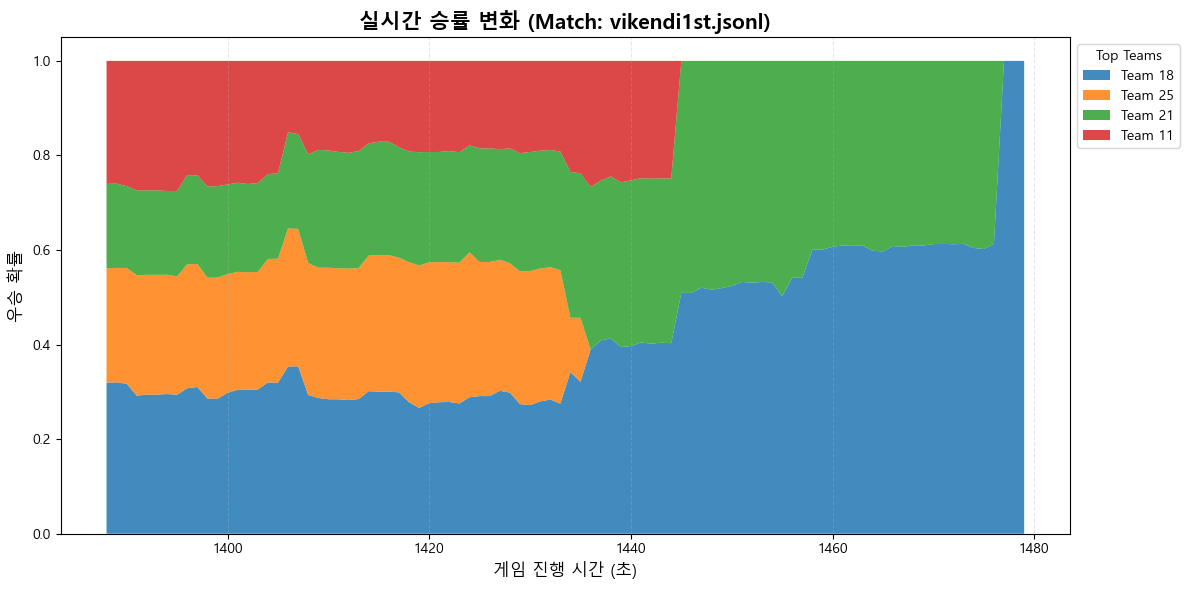

✨ 그래프 생성 완료!


In [80]:
import matplotlib.pyplot as plt
# ==========================================
# [실행부] 실제 데이터 추론 (v1 기반)
# ==========================================
TARGET_LOG_FILE = 'vikendi1st.jsonl'
MODEL_PATH = 'pubg_win_model_v2_datav3.pth'
TIME_INTERVAL_SEC = 1

# 2-1 모델 변수 구성 (17개)
P_COLS = [
    'hp', 'groggy',
    'medkit', 'firstaid', 'painkiller', 'drink', 'adrenaline',
    'smoke', 'grenade', 'flash', 'molotov',
    'helm', 'vest',
    'kill',
    'dX', 'dY', 'z_norm'
]
T_COLS = ['num_alive', 'total_health']

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 폰트 설정 (한글 깨짐 방지)
    if os.name == 'nt': 
        plt.rc('font', family='Malgun Gothic')
    plt.rc('axes', unicode_minus=False)

    if not os.path.exists(TARGET_LOG_FILE):
        print(f"❌ 분석할 파일({TARGET_LOG_FILE})이 없습니다.")
    elif not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일({MODEL_PATH})이 없습니다.")
    else:
        # 1. 모델 로드 (weights_only=False)
        try:
            checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
            
            model = WinPredictor().to(device)
            model.load_state_dict(checkpoint['model'])
            p_scaler = checkpoint['p_scaler']
            t_scaler = checkpoint['t_scaler']
            model.eval()
            
            print(f"✅ 모델 로드 완료 (Device: {device})")
            
            # 2. 데이터 추출
            print(f"🚀 '{TARGET_LOG_FILE}' 분석 중...")
            df = process_match_log(TARGET_LOG_FILE)
            
            if df is None or df.empty:
                print("❌ 데이터 추출 실패")
            else:
                df.to_csv("jinu_example.csv", index=False)
                print(f"✅ 데이터 추출 완료 ({len(df)} 스냅샷)")

                # 3. 추론 (Inference)
                time_steps = df['time_sec'].unique()
                history_probs = []
                
                # 초기 생존 팀 기준으로 그래프 색상/순서 고정 (0번 팀 제외)
                initial_teams = df[df['time_sec'] == time_steps[0]]['team_id'].values
                initial_teams = [tid for tid in initial_teams if tid != 0]  # 0번 팀 제외
                team_to_idx = {tid: i for i, tid in enumerate(initial_teams)}

                print("📊 승률 계산 중...")
                with torch.no_grad():
                    for t_sec in time_steps:
                        step_df = df[df['time_sec'] == t_sec]
                        
                        # 각 시간대별 팀의 승률을 저장할 리스트
                        time_probs = []
                        
                        # 각 팀마다 개별로 예측
                        for tid in team_to_idx.keys():
                            team_row = step_df[step_df['team_id'] == tid]
                            
                            if team_row.empty:
                                time_probs.append(0.0)  # 팀이 없으면 0
                                continue
                            
                            row = team_row.iloc[0]
                            
                            # Player Data (4명, 17개 특징)
                            p_data = []
                            for i in range(4):
                                cols = [f"P{i+1}_{c}" for c in P_COLS]
                                raw_p = row[cols].values.reshape(1, -1)  # (1, 17)
                                scaled_p = p_scaler.transform(raw_p)     # (1, 17)
                                p_data.append(scaled_p[0])               # (17,) 저장
                            p_tensor = np.stack(p_data, axis=0)  # (4, 17)
                            
                            # Team Data (2개 특징)
                            raw_t = row[T_COLS].values.reshape(1, -1)  # (1, 2)
                            t_tensor = t_scaler.transform(raw_t)        # (1, 2)
                            
                            # Batch 차원 추가: (1, 4, 17), (1, 2)
                            p_in = torch.FloatTensor(p_tensor).unsqueeze(0).to(device)  # (1, 4, 17)
                            t_in = torch.FloatTensor(t_tensor).to(device)               # (1, 2)
                            
                            # 모델 실행
                            pred = model(p_in, t_in)
                            prob = pred.cpu().numpy()[0][0]  # Sigmoid 출력값
                            time_probs.append(prob)
                        
                        # ★ [정규화] 확률 합이 1이 되도록 조정
                        prob_sum = sum(time_probs)
                        if prob_sum > 0:
                            time_probs = [p / prob_sum for p in time_probs]
                        
                        history_probs.append(time_probs)

                # 4. 시각화
                history_probs = np.array(history_probs).T  # (Teams, Time)
                
                # 마지막 시점 승률 높은 순으로 정렬 (Top 5)
                last_probs = history_probs[:, -1]
                top_indices = np.argsort(last_probs)[::-1][:5]
                
                plt.figure(figsize=(12, 6))
                labels = [f"Team {list(team_to_idx.keys())[i]}" for i in top_indices]
                
                # Stackplot
                plt.stackplot(time_steps, history_probs[top_indices], labels=labels, alpha=0.85)
                
                plt.title(f"실시간 승률 변화 (Match: {TARGET_LOG_FILE})", fontsize=15, fontweight='bold')
                plt.xlabel("게임 진행 시간 (초)", fontsize=12)
                plt.ylabel("우승 확률", fontsize=12)
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Top Teams")
                plt.grid(axis='x', linestyle='--', alpha=0.3)
                plt.tight_layout()
                
                plt.show()
                print("✨ 그래프 생성 완료!")
                
        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            import traceback
            traceback.print_exc()

In [82]:
time_steps

array([1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398,
       1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409,
       1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420,
       1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431,
       1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442,
       1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453,
       1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464,
       1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475,
       1476, 1477, 1478, 1479], dtype=int64)

In [85]:
history_probs

array([[2.60045219e-01, 2.59574393e-01, 2.64999777e-01, 2.73605003e-01,
        2.73710296e-01, 2.73743666e-01, 2.75258745e-01, 2.75022681e-01,
        2.41553290e-01, 2.42014882e-01, 2.65262953e-01, 2.64871891e-01,
        2.61323344e-01, 2.57669387e-01, 2.60429793e-01, 2.58536131e-01,
        2.39472030e-01, 2.37774381e-01, 1.51034583e-01, 1.54893314e-01,
        1.97561891e-01, 1.88235075e-01, 1.89348267e-01, 1.92415294e-01,
        1.94466047e-01, 1.90737934e-01, 1.74287419e-01, 1.70795294e-01,
        1.70795294e-01, 1.82597876e-01, 1.91791262e-01, 1.93134941e-01,
        1.92794033e-01, 1.92562356e-01, 1.90735746e-01, 1.93127050e-01,
        1.78716026e-01, 1.84901265e-01, 1.84901265e-01, 1.86812244e-01,
        1.84950718e-01, 1.95077956e-01, 1.92712740e-01, 1.89866021e-01,
        1.88428178e-01, 1.91562546e-01, 2.34814423e-01, 2.37827609e-01,
        2.66625963e-01, 2.53429858e-01, 2.44252967e-01, 2.56856875e-01,
        2.52698427e-01, 2.48023017e-01, 2.49267676e-01, 2.484322

In [89]:
import os

# ==========================================
# [타임스탬프별 승률 누적막대그래프 저장]
# ==========================================

# 저장할 폴더 생성
output_folder = "frames"
os.makedirs(output_folder, exist_ok=True)

print(f"📊 {len(time_steps)}개의 타임스탬프별 그래프 생성 중...")

# 팀별 색상 지정
team_colors = {
    18: '#8B4513',  # 갈색 (brown)
    25: '#808000',  # 올리브색 (olive)
    11: '#FFD700',  # 노란색 (gold)
    21: '#87CEEB'   # 하늘색 (sky blue)
}

# 각 타임스탬프마다 그래프 생성
for idx, t_sec in enumerate(time_steps):
    # 해당 시점의 승률 데이터
    probs_at_t = history_probs[:, idx]
    
    # 승률 높은 순으로 정렬 (Top 10, 모든 팀)
    sorted_indices = np.argsort(probs_at_t)[::-1]
    sorted_teams = [list(team_to_idx.keys())[i] for i in sorted_indices]
    sorted_probs = probs_at_t[sorted_indices]
    
    # 그래프 생성 (가로로 길게)
    fig, ax = plt.subplots(figsize=(16, 3))
    
    # 누적 막대그래프 (수평)
    left = 0
    for i, (team, prob) in enumerate(zip(sorted_teams, sorted_probs)):
        # 팀별 색상 지정, 없으면 기본 회색
        color = team_colors.get(team, '#808080')
        
        ax.barh(0, prob, left=left, height=0.8, 
                color=color, edgecolor='white', linewidth=2)
        
        # 확률이 3% 이상일 때만 텍스트 표시
        if prob > 0.03:
            ax.text(left + prob/2, 0, f"{prob*100:.1f}%", 
                   ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        
        left += prob
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')  # 모든 축 제거
    
    plt.tight_layout(pad=0)
    
    # 파일명: frame_0000.png, frame_0001.png, ...
    filename = os.path.join(output_folder, f"frame_{idx:04d}.png")
    plt.savefig(filename, dpi=100, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    # 진행 상황 출력 (10개마다)
    if (idx + 1) % 10 == 0 or (idx + 1) == len(time_steps):
        print(f"  ✅ {idx + 1}/{len(time_steps)} 프레임 저장 완료")

print(f"\n🎉 모든 그래프가 '{output_folder}' 폴더에 저장되었습니다!")
print(f"📂 총 {len(time_steps)}개 파일 생성 완료")

📊 92개의 타임스탬프별 그래프 생성 중...
  ✅ 10/92 프레임 저장 완료
  ✅ 10/92 프레임 저장 완료
  ✅ 20/92 프레임 저장 완료
  ✅ 20/92 프레임 저장 완료
  ✅ 30/92 프레임 저장 완료
  ✅ 30/92 프레임 저장 완료
  ✅ 40/92 프레임 저장 완료
  ✅ 40/92 프레임 저장 완료
  ✅ 50/92 프레임 저장 완료
  ✅ 50/92 프레임 저장 완료
  ✅ 60/92 프레임 저장 완료
  ✅ 60/92 프레임 저장 완료
  ✅ 70/92 프레임 저장 완료
  ✅ 70/92 프레임 저장 완료
  ✅ 80/92 프레임 저장 완료
  ✅ 80/92 프레임 저장 완료
  ✅ 90/92 프레임 저장 완료
  ✅ 92/92 프레임 저장 완료

🎉 모든 그래프가 'frames' 폴더에 저장되었습니다!
📂 총 92개 파일 생성 완료
  ✅ 90/92 프레임 저장 완료
  ✅ 92/92 프레임 저장 완료

🎉 모든 그래프가 'frames' 폴더에 저장되었습니다!
📂 총 92개 파일 생성 완료
